<a href="https://colab.research.google.com/github/fe7565/sf11/blob/master/Another_copy_of_Doppler_radar_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simulation of the Radar Signal Processing**

In [ ]:
#Parameters
RADAR_DETECTION_RANGE = 1.5 # m, the total distance the radar is able to
BULLET_VELOCITY = 1498.7 # m/s
RADAR_FREQUENCY = 24e9 # Hz
RADAR_RMS_NOISE = 116e-3  # RMS voltage of noise in volts

SNR = 0.03 # Signal to noise ratio (20dB = 0.01)

MAX_BULLET_VELOCITY = 1500 # m/s
MIN_BULLET_VELOCITY = 150 # m/s
RES_VELOCITY = 0.5 # Resolution on velocity

# Filter
FILTER_AMP = 20 # Amplification of signal

Time during the bullet is visible to radar:  1.0009 ms
Doppler Frequency from bullet:  239793 Hz


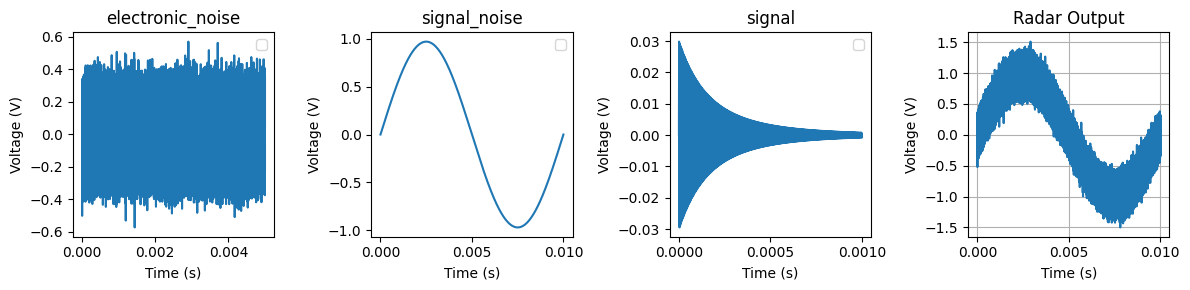

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

c = 3e8 # m/s, speed of light

def bullet_vel_to_doppler(velocity:float)->float:
    # fd = 2*v*f/(c-v)
    return 2*velocity*RADAR_FREQUENCY/(c-velocity)

def doppler_to_bullet_vel(fd:float)->float:
    return fd*c/(2*RADAR_FREQUENCY+fd)

sample_rate = 1e8 # Sample rate used for the analog signal (not A/D-sampling, nor the micro-controller sampling)
bullet_capture_t = RADAR_DETECTION_RANGE/BULLET_VELOCITY # The time in which the bullet is in range for the radar
duration = 2e-2 # Duration for the analog signal (not the duration of the micro-controller sampling)
t = np.arange(0, duration, 1/sample_rate)

background_doppler = 1e2  # Some background noise
projectile_doppler = bullet_vel_to_doppler(BULLET_VELOCITY)

print(f"Time during the bullet is visible to radar: {1000*bullet_capture_t: .4f} ms")
print(f"Doppler Frequency from bullet: {projectile_doppler: .0f} Hz")

electronic_noise = np.random.normal(0, RADAR_RMS_NOISE, len(t))
signal_noise = (1-SNR)*np.sin(2 * np.pi * background_doppler * t)
r = BULLET_VELOCITY * t + 1.0  # We put radar 1 meter from the barrel exit
signal = (1 / r**4) * SNR * np.sin(2 * np.pi * projectile_doppler * t)
radar_output = electronic_noise + signal_noise + signal

# Plotting
plt.figure(figsize=(12, 3))

ps = 100000
plt.subplot(1, 4, 1)
plt.plot(t[:5*ps], electronic_noise[:5*ps])
plt.title('electronic_noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(t[:10*ps], signal_noise[:10*ps])
plt.title('signal_noise')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(t[:ps], signal[:ps])
plt.title('signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(t[:ps*10], radar_output[:10*ps])
plt.title('Radar Output')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

plt.tight_layout()
plt.show()


**Active Band-Pass Filter**

We later apply band-pass *filter*

Filter AMP: 20


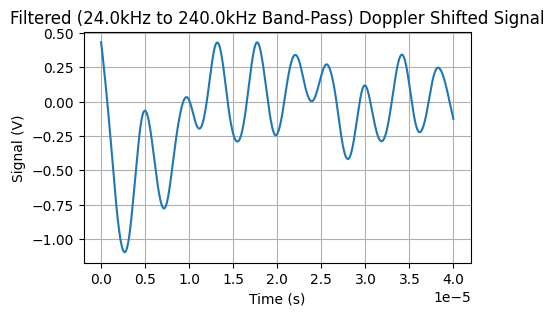

In [ ]:
from scipy.signal import butter, filtfilt

min_doppler_freq = bullet_vel_to_doppler(MIN_BULLET_VELOCITY)
max_doppler_freq = bullet_vel_to_doppler(MAX_BULLET_VELOCITY)

# Design a second-order band-pass filter
nyquist_rate = sample_rate / 2
low_cutoff = min_doppler_freq / nyquist_rate
high_cutoff = max_doppler_freq / nyquist_rate
b, a = butter(N=2, Wn=[low_cutoff, high_cutoff], btype='band')

# Apply filter with amplification
filter_output = FILTER_AMP*filtfilt(b, a, radar_output)
print(f"Filter AMP: {FILTER_AMP}")

# Plotting
x_lim = len(t)//500
plt.figure(figsize=(5, 3))
plt.plot(t[:x_lim], filter_output[:x_lim], label='Filtered Signal')
plt.title(f'Filtered ({min_doppler_freq/1000:.1f}kHz to {max_doppler_freq/1000:.1f}kHz Band-Pass) Doppler Shifted Signal')
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.grid(True)
plt.show()

**Insert Bias and Gain**

We want the mean of the signal to be in the middle of the Analog Read range (0-3.3V)

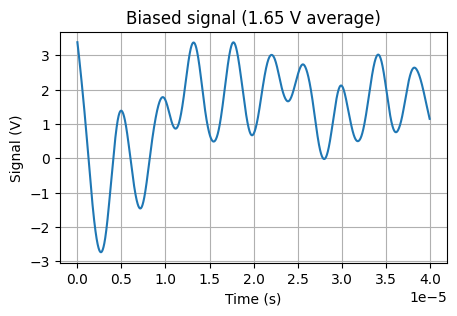

In [ ]:
# Current and desired mean
current_mean = np.mean(filter_output)
desired_mean = 3.3 / 2

GAIN = 4
zero_mean_output = filter_output - current_mean
gain_applied_output = GAIN * zero_mean_output

# Step 4: Reintroduce the desired mean
offset_output = gain_applied_output + desired_mean

# Plotting the adjusted signal
x_lim = len(t) // 500
plt.figure(figsize=(5, 3))
plt.plot(t[:x_lim], offset_output[:x_lim])
plt.title(f'Biased signal ({desired_mean} V average)')
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.grid(True)
plt.show()

**Zener diode**

Before we send the signal to the MCU we need to be sure that no voltages above 3.3 or below 0V is in the signal.

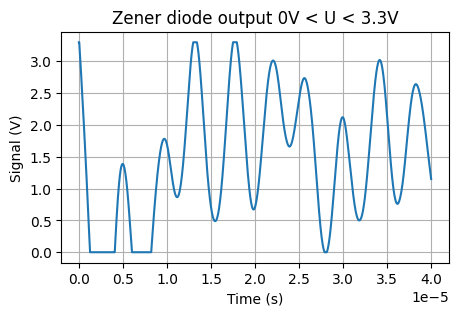

In [ ]:
zener_output = np.clip(offset_output, 0, 3.3)

x_lim = len(t)//500
plt.figure(figsize=(5, 3))
plt.plot(t[:x_lim], zener_output[:x_lim])
plt.title(f'Zener diode output 0V < U < 3.3V')
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.grid(True)
plt.show()

**Micro controller**

We simulate a MC that samples from an analog input and stores the values into memory.

Sample duration: 1.00 ms
Bytes per sample: 2
Number of samples: 1000
RAM required to store samples: 2.0 kb


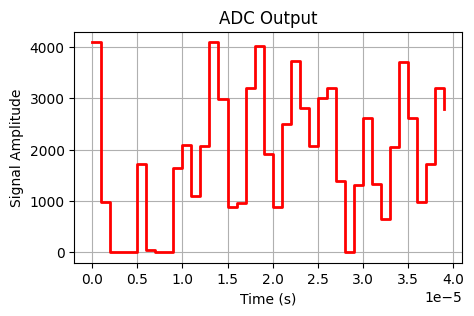

In [ ]:
from math import ceil
MC_SAMPLE_RATE = 1.0e6 # Hz, Not the CPU Clock Frequency but rather how quickly it can store readings into memory
MC_SAMPLE_BITS = 12 # Resolution on A/D conversion

mc_sample_levels = 2 ** MC_SAMPLE_BITS
mc_sample_duration = bullet_capture_t # Sample for as long as the bullet is visible

mc_n_samples = int(MC_SAMPLE_RATE*mc_sample_duration)
byte_per_sample = ceil(MC_SAMPLE_BITS/8)
print(f"Sample duration: {mc_sample_duration*1000:.2f} ms")
print(f"Bytes per sample: {byte_per_sample}")
print(f"Number of samples: {mc_n_samples}")
print(f"RAM required to store samples: {mc_n_samples*byte_per_sample/1_000:.2} kb")

# Sample the filtered signal at the ADC sample rate
mc_t_samples = np.arange(0, mc_sample_duration, 1/MC_SAMPLE_RATE)  # ADC sample times
mc_sample_indices = np.round(mc_t_samples * sample_rate).astype(int)
mc_samples = zener_output[mc_sample_indices]

V_min, V_max = 0, 3.3  # Volts

voltage_step = (V_max - V_min) / (mc_sample_levels - 1)
scaled_signal = (mc_samples - V_min) / (V_max - V_min) * (mc_sample_levels - 1)
adc_output = np.round(scaled_signal)

# Plotting
plt.figure(figsize=(5, 3))
x_lim = len(t)//50000
# Plot the ADC samples as blocks
plt.step(mc_t_samples[:x_lim], adc_output[:x_lim], where='post', color='r', linewidth=2, label='ADC Samples (Blocks)')

plt.title('ADC Output')
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplitude')
plt.grid(True)
plt.show()

Finally we generate the FFT plot using the data in memory

Desired velocity resolution: 0.5 m/s
FFT Resolution without padding: 1000 Hz (6.25 m/s)
N Samples: 1001
N required: 12500
Padding signal with 11499 zeros


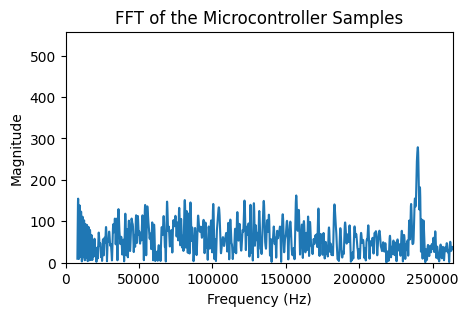

In [ ]:
from scipy.fft import fft, fftfreq
import math

res_freq = RES_VELOCITY*bullet_vel_to_doppler(MAX_BULLET_VELOCITY)/MAX_BULLET_VELOCITY
n_samp_required = math.ceil(MC_SAMPLE_RATE/res_freq)
print(f"Desired velocity resolution: {RES_VELOCITY} m/s")
fft_res = MC_SAMPLE_RATE/mc_n_samples
print(f"FFT Resolution without padding: {fft_res:.0f} Hz ({doppler_to_bullet_vel(fft_res):.2f} m/s)")
print(f"N Samples: {len(adc_output)}")
print(f"N required: {n_samp_required}")
PADDING = n_samp_required - len(adc_output)
print(f"Padding signal with {PADDING} zeros")
signal_padded = np.concatenate((adc_output, np.array(PADDING*[0.0])))

# Perform FFT on the microcontroller samples
fft_values = fft(signal_padded)

# Calculate the corresponding frequencies for each FFT sample
# Use the effective sampling rate for the microcontroller
fft_freq = fftfreq(len(signal_padded), 1 / MC_SAMPLE_RATE)

# Plotting the FFT results
plt.figure(figsize=(5, 3))

# As the FFT output is symmetrical, we take half the array for plotting (positive frequencies)
half_n = len(fft_freq) // 2
magnitude = 2.0/len(mc_samples) * np.abs(fft_values[:half_n])

# Plot magnitude spectrum using a line plot
plt.plot(fft_freq[:half_n][100:], magnitude[100:], label='Magnitude')

peak_index = np.argmax(magnitude)
peak_f = fft_freq[peak_index]
measured_v = doppler_to_bullet_vel(peak_f)
delta = BULLET_VELOCITY-measured_v
plt.annotate(f'{peak_f/1000:.2f} kHz\nMeasured: {measured_v:.2f} m/s\nTrue: {BULLET_VELOCITY:.2f} m/s\nerror Δ = {delta:.2f} m/s',
              (fft_freq[peak_index], magnitude[peak_index]),
              textcoords="offset points",
              xytext=(-71,25),
              ha='center',
              arrowprops=dict(facecolor='black', shrink=0.05))

# Plotting details
plt.title('FFT of the Microcontroller Samples')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 1.1*max_doppler_freq)
plt.ylim(0, 2*max(magnitude[100:]))
plt.grid(False)
plt.show()